In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import special

import seaborn as sns

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)

In [3]:
def f_rate_0(ge, gi, vl=-80, ve=0, vi=-60, vt=-60, vr=-70, tr=0, tm= 0.02):
    
    # calculating firing rate of an LIF model without noise in units of Hz
    # ge: glu conductance relative to leak conductance (unitless)
    # gi: gaba conductance relative to leak conductance (unitless)
    # vl: leak reversal (mV)
    # ve: glu reversal (mV)
    # vi: gaba reversal (mV)
    # vt: spike treshold (mV)
    # vr: reset potential (mV)
    # tr: refractory period (s)
    # tm: membrane time constant (s)
    
    v_eff = (vl + ge*ve + gi*vi)/(1+ge+gi)
    if v_eff>vt:
        
        tau = tm * np.log((v_eff-vr)/(v_eff-vt)) / (1+ge+gi) + tr
        firing_rate = 1/tau
        
    else:
        
        firing_rate = 0
    
    return(firing_rate)

In [4]:
def nerf(z):
    
    # function exp(z^2)(erf(z)+1)  
    
    a1 = -1.26551223
    a2 = 1.00002368
    a3 = 0.37409196
    a4 = 0.09678418
    a5 = -0.18628806
    a6 = 0.27886087
    a7 = -1.13520398
    a8 = 1.48851587
    a9 = -0.82215223
    a10 = 0.17087277

    w = np.abs(z);
    t = 1.0/(1.0 + 0.5 * w);
    at = a1+t*(a2+t*(a3+t*(a4+t*(a5+t*(a6+t*(a7+t*(a8+t*(a9+t*a10))))))));
    ef = t*np.exp(at);
    if (z>0.0e0):
            ef = 2.0*np.exp(w*w)-ef;  
    return(ef);


def trans(ge, gi, sigma, vl=-80, ve=0, vi=-60, vt=-60, vr=-70, tm= 0.02, taurp=0):
    
    # transfer function (firing rate as a function of noise sigma)
    
    veff = (vl + ge*ve + gi*vi)/(1+ge+gi)   # effective potential
    tau = tm/(1+ge+gi)                      # effective time constant
    sigma_eff = sigma/np.sqrt(1+ge+gi)         # effectvie sigma noise
    
    x = (vt-veff)/sigma_eff
    y = (vr-veff)/sigma_eff
    
    SQPI = np.sqrt(4.*np.arctan(1.))
    
    w=0.0;
    
    if (x<-100 and y<-100):
        
        w = np.log(y/x) - 0.25/(x*x) + 0.25/(y*y);
        w = 1./(taurp+tau*w);
        
    elif (y<-100.):
        
        ylow = -100.; 
        N = int(100.*(x-ylow));
        
        for i in range(N+1):
            
            z = ylow + (x-ylow)*i/N;
            cont = nerf(z);
            
            if (i==0 or i==N): 
                w += 0.5*cont;
            else: 
                w += cont;
    
        w *= (x-ylow)*SQPI/N;
        w += np.log(-y/100.)-0.000025+0.25/(y*y);
        w = 1./(taurp+tau*w);

    else:
        
        ylow = y;
        N = int(100.*(x-ylow));
        
        for i in range(N+1):
        
            z = ylow + (x-ylow)*i/N;
            cont = nerf(z);
        
            if (i==0 or i==N):
                w += 0.5*cont;
            else: 
                w += cont;
    
        w *= (x-ylow)*SQPI/N;
        w = 1./(taurp+tau*w);
  
    return(w);

    
    

## find g_Glu for which firing rate is 1Hz

In [103]:
sigma_list = [1,2,3,4,5,6,7,8,9,10]
ge_list = np.arange(0,0.4, step=0.001)
frate_list = np.zeros((len(sigma_list), len(ge_list)))

for (ind1, sigma) in tqdm(enumerate(sigma_list)):
    
    for (ind2, ge) in enumerate(ge_list):

        frate_list[ind1, ind2] = trans(ge=ge, gi=0, sigma=sigma)

In [104]:
n = frate_list.shape[0]
ge_1Hz = np.zeros(n)

for ind in range(n):
    frate = frate_list[ind, :]
    ge_1Hz[ind] = ge_list[np.argmin(np.abs(frate-1))]
    
ge_1Hz

array([0.258, 0.187, 0.122, 0.06 , 0.002])

In [115]:
gi_list = np.arange(0,10, step=0.01)
frate_list_2 = np.zeros((len(sigma_list), len(gi_list)))

for ind1, ge in tqdm(enumerate(ge_1Hz)):
    
    for ind2, gi in enumerate(gi_list):
        
        frate_list_2[ind1, ind2] = trans(ge=ge, gi=gi, sigma=sigma_list[ind1], vi=-65)
    


Text(0, 0.5, 'firing rate (Hz)')

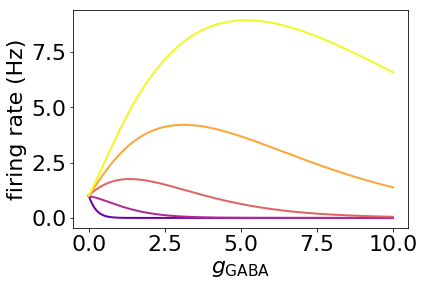

In [116]:
cmap = mpl.cm.get_cmap('plasma')
n_lines = frate_list_2.shape[0]
color_list = [cmap(i/n_lines) for i in range(1, n_lines+1)]

for ind in range(n_lines):

    plt.plot(gi_list, frate_list_2[ind], color=color_list[ind], linewidth=2)

plt.xlabel(r'$g_{\rm GABA}$')
plt.ylabel('firing rate (Hz)')

plt.savefig('f_curve_noise_vi-65.svg')


## finding f-I curves

In [5]:
sigma_list = [2,4,6,8,10]
ge_list = np.arange(0,1, step=0.001)
frate_list = np.zeros((len(sigma_list), len(ge_list)))

for (ind1, sigma) in tqdm(enumerate(sigma_list)):
    
    for (ind2, ge) in enumerate(ge_list):

        frate_list[ind1, ind2] = trans(ge=ge, gi=0, sigma=sigma)

In [6]:
frate_zero_noise = np.zeros((len(ge_list)))

for ind, ge in enumerate(ge_list):

    frate_zero_noise[ind] = f_rate_0(ge=ge, gi=0) 
    
frate_list_all = np.vstack((frate_zero_noise, frate_list))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


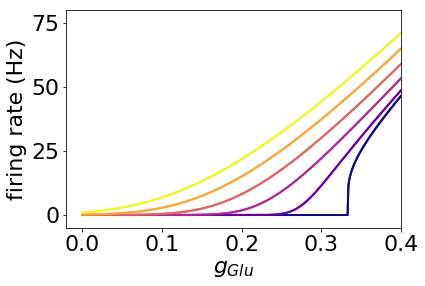

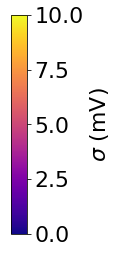

In [9]:
cmap = mpl.cm.get_cmap('plasma')
n_lines = frate_list_all.shape[0]-1
color_list = [cmap(i/n_lines) for i in range(n_lines+1)]

for ind in range(n_lines+1):

    plt.plot(ge_list, frate_list_all[ind], color=color_list[ind], linewidth=2)

plt.xlabel(r'$g_{Glu}$')
plt.ylabel('firing rate (Hz)')
#plt.xlim((-0.02, 0.52))
#plt.ylim((-2, 22))
#plt.legend(labels=['0','2','4','6','8','10'], title="sigma (mV)",
#                    fontsize='small', fancybox=True)
plt.savefig('f_curve_noise.svg')


## Zoomed version

cmap = mpl.cm.get_cmap('plasma')
n_lines = frate_list_all.shape[0]-1
color_list = [cmap(i/n_lines) for i in range(n_lines+1)]

for ind in range(n_lines+1):

    plt.plot(ge_list, frate_list_all[ind], color=color_list[ind], linewidth=2)

plt.xlabel(r'$g_{Glu}$')
plt.ylabel('firing rate (Hz)')
plt.xlim((-0.02, 0.4))
plt.ylim((-5, 80))
#plt.legend(labels=['0','2','4','6','8','10'], title="sigma (mV)",
#                    fontsize='small', fancybox=True)
plt.savefig('f_curve_noise_zoomed.svg')
plt.savefig('f_curve_noise_zoomed.png')


## colorbar

fig, ax = plt.subplots(figsize=(0.3, 8))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'$\sigma$ (mV)')
fig.show()
plt.savefig('f_curve_noise_colorbar.svg')
plt.savefig('f_curve_noise_colorbar.png')


In [23]:
sigma_list = [1,2,3,4,5,6,7,8,9,10]
gi_list = np.arange(0,10, step=0.1)
frate_list = np.zeros((len(sigma_list), len(gi_list)))

for (ind1, sigma) in tqdm(enumerate(sigma_list)):
    
    for (ind2, gi) in enumerate(gi_list):

        frate_list[ind1, ind2] = trans(ge=0.25, gi=gi, sigma=sigma, vi=-65)

Text(0, 0.5, 'normalized firing rate')

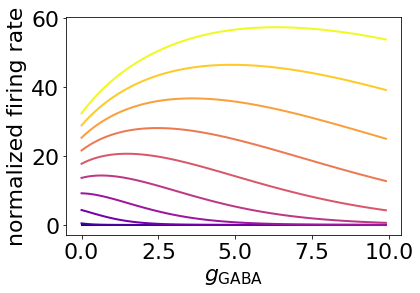

In [25]:
cmap = mpl.cm.get_cmap('plasma')
n_lines = frate_list.shape[0]
color_list = [cmap(i/n_lines) for i in range(1, n_lines)]

for ind in range(n_lines+1):

    plt.plot(gi_list, frate_list[ind,:], color=color_list[ind], linewidth=2)

plt.xlabel(r'$g_{\rm GABA}$')
plt.ylabel('firing rate (Hz)')
#plt.savefig('f_curve_noise.svg')



In [13]:
frate_list[0][0]

0.4578098758792816

## Phase diagrams with noise

In [22]:
sigma = 4 # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

dfrate = np.zeros((len(ge_list), len(vi_list)))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        frate1 = trans(ge=ge, gi=0, sigma=sigma, vi=vi)
        frate2 = trans(ge=ge, gi=0.01, sigma=sigma, vi=vi)
        dfrate[ind1, ind2] = (frate2 - frate1)/0.01
        

In [6]:
#changing derivative steps

sigma = 2 # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

dfrate = np.zeros((len(ge_list), len(vi_list)))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        frate1 = trans(ge=ge, gi=0, sigma=sigma, vi=vi)
        frate2 = trans(ge=ge, gi=0.1, sigma=sigma, vi=vi)
        dfrate[ind1, ind2] = (frate2 - frate1)/0.1
        

In [47]:
sigma = 10 # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

dfrate = np.zeros((len(ge_list), len(vi_list)))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        frate1 = trans(ge=ge, gi=0, sigma=sigma, vi=vi)
        frate2 = trans(ge=ge, gi=0.01, sigma=sigma, vi=vi)
        dfrate[ind1, ind2] = (frate2 - frate1)/0.01
        

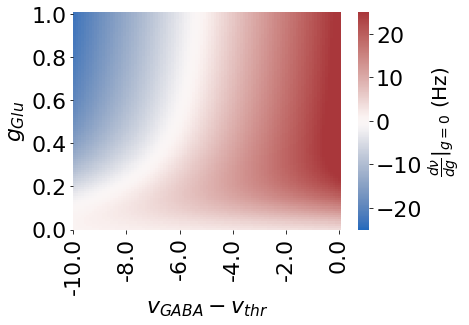

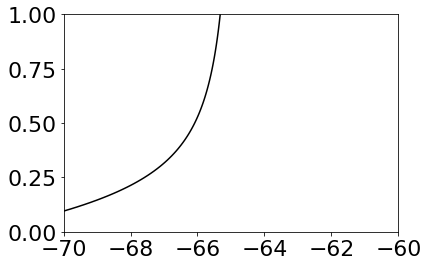

In [48]:
fig = plt.figure()


num_ticks = 6
yticks = np.linspace(0, len(ge_list) - 1, num_ticks, dtype=np.int)
yticklabels = np.array([ge_list[idx] for idx in yticks])
num_ticks = 6
xticks = np.linspace(0, len(vi_list) - 1, num_ticks, dtype=np.int)
xticklabels = np.array([vi_list[idx]-(-60) for idx in xticks])


ax = sns.heatmap(dfrate, 
                 xticklabels=np.round(xticklabels, decimals=1), 
                 yticklabels=np.round(yticklabels, decimals=2), 
                 cbar_kws={'label': r'$\frac{d\nu}{dg}|_{g=0}$ (Hz)'},
                 cmap="vlag", vmin=-25, vmax=+25);
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.invert_yaxis();
ax.set_yticks(yticks)
ax.set_xticks(xticks)


plt.xlabel(r'$v_{GABA}-v_{thr}$');
plt.ylabel(r'$g_{Glu}$');
#plt.title(r'GABA effect phase diagram')

plt.savefig('phasediagram_reversal_vs_glu_sigma10.png', dpi=500, transparent=True, bbox_inches='tight')

# contours
plt.figure()
levels=[0.01] # Define levels 

ct=plt.contour(vi_list,ge_list,dfrate,levels, colors='black')

plt.savefig('heatmap_contours_sigma10.svg')

## max of transfer function in non-monotonic region

In [10]:
# with noise

sigma = 6 # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

gi_list = np.logspace(-1,2,201)

argmax_frate = np.zeros((len(ge_list), len(vi_list)))
frate = np.zeros(len(gi_list))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        for ind3,gi in enumerate(gi_list):
        
            frate[ind3] = trans(ge=ge, gi=gi, sigma=sigma, vi=vi)
        
        argmax_frate[ind1, ind2] = gi_list[np.argmax(frate)]

In [63]:
# without noise

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

gi_list = np.logspace(-1,2,201)

argmax_frate_2 = np.zeros((len(ge_list), len(vi_list)))
frate_2 = np.zeros(len(gi_list))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        for ind3,gi in enumerate(gi_list):
        
            frate_2[ind3] = f_rate_0(ge=ge, gi=gi, vi=vi)
        
        argmax_frate_2[ind1, ind2] = gi_list[np.argmax(frate_2)]

In [11]:
# saving array
np.savetxt("argmax_frate_phasespace_sigma6.txt", argmax_frate)
# loading array
ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)
#argmax_frate = np.loadtxt("argmax_frate_phasespace_sigma2.txt")

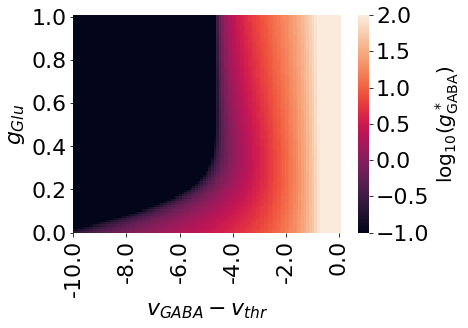

In [12]:
fig = plt.figure()


num_ticks = 6
yticks = np.linspace(0, len(ge_list) - 1, num_ticks, dtype=np.int)
yticklabels = np.array([ge_list[idx] for idx in yticks])
num_ticks = 6
xticks = np.linspace(0, len(vi_list) - 1, num_ticks, dtype=np.int)
xticklabels = np.array([vi_list[idx]-(-60) for idx in xticks])


ax = sns.heatmap(np.log10(argmax_frate), 
                 xticklabels=np.round(xticklabels, decimals=1), 
                 yticklabels=np.round(yticklabels, decimals=2), 
                 cbar_kws={'label': r'$\log_{10}(g^*_{\rm GABA})$'}
                    );
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.invert_yaxis();
ax.set_yticks(yticks)
ax.set_xticks(xticks)


plt.xlabel(r'$v_{GABA}-v_{thr}$');
plt.ylabel(r'$g_{Glu}$');
#plt.title(r'GABA effect phase diagram')

plt.savefig('phasediagram_max_gGABA_sigma6.png', dpi=500, transparent=True, bbox_inches='tight')


In [13]:
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

NameError: name 'cax' is not defined

## change of firing rate in non-monotonic region

In [5]:
# with noise

sigma = 2 # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

gi_list = np.logspace(-1,2,201)

max_over_initial_frate = np.zeros((len(ge_list), len(vi_list)))
frate = np.zeros(len(gi_list))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        for ind3,gi in enumerate(gi_list):
        
            frate[ind3] = trans(ge=ge, gi=gi, sigma=sigma, vi=vi)
        
        max_over_initial_frate[ind1, ind2] = np.max(frate)/frate[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in double_scalars


In [127]:
# without noise

ge_list = np.linspace(0,1,201)
vi_list = np.linspace(-70,-60,201)

gi_list = np.logspace(-1,2,201)

max_over_initial_frate_0 = np.zeros((len(ge_list), len(vi_list)))
frate_0 = np.zeros(len(gi_list))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    for ind2,vi in enumerate(vi_list):
        
        for ind3,gi in enumerate(gi_list):
        
            frate_0[ind3] = f_rate_0(ge=ge, gi=gi, vi=vi)
        
        max_over_initial_frate_0[ind1, ind2] = np.max(frate_0)/frate_0[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


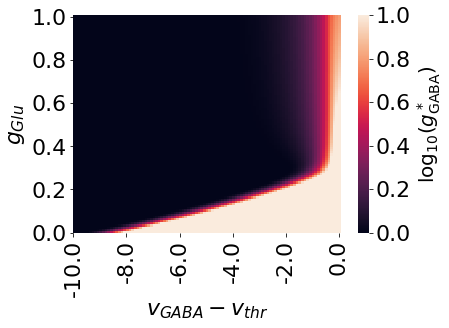

In [8]:
fig = plt.figure()


num_ticks = 6
yticks = np.linspace(0, len(ge_list) - 1, num_ticks, dtype=np.int)
yticklabels = np.array([ge_list[idx] for idx in yticks])
num_ticks = 6
xticks = np.linspace(0, len(vi_list) - 1, num_ticks, dtype=np.int)
xticklabels = np.array([vi_list[idx]-(-60) for idx in xticks])


ax = sns.heatmap(np.log10(max_over_initial_frate), 
                 xticklabels=np.round(xticklabels, decimals=1), 
                 yticklabels=np.round(yticklabels, decimals=2), 
                 cbar_kws={'label': r'$\log_{10}(g^*_{\rm GABA})$'}, vmin=0, vmax=1
                    );
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.invert_yaxis();
ax.set_yticks(yticks)
ax.set_xticks(xticks)


plt.xlabel(r'$v_{GABA}-v_{thr}$');
plt.ylabel(r'$g_{Glu}$');
#plt.title(r'GABA effect phase diagram')

plt.savefig('phasediagram_max_over_initial_frate_sigma2_black.png', dpi=500, transparent=True, bbox_inches='tight')


## different regimes plots

### zero crossing of transfer function

In [34]:
sigma_list = np.linspace(1,10,num=11)
ge_list = np.arange(0,1, step=0.01)
frate_list = np.zeros((len(sigma_list), len(ge_list)))

for (ind1, sigma) in tqdm(enumerate(sigma_list)):
    
    for (ind2, ge) in enumerate(ge_list):

        frate_list[ind1, ind2] = trans(ge=ge, gi=0, sigma=sigma)
        
zero_crossings = ge_list[np.argmax(frate_list>0.01, axis=1)]

In [72]:
sigma_list = np.linspace(1,10,num=10) # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

dfrate = np.zeros((len(sigma_list), len(ge_list), len(vi_list)))

for ind0,sigma in tqdm(enumerate(sigma_list)):

    for ind1,ge in enumerate(ge_list):
    
        for ind2,vi in enumerate(vi_list):
        
            frate1 = trans(ge=ge, gi=0, sigma=sigma, vi=vi)
            frate2 = trans(ge=ge, gi=0.01, sigma=sigma, vi=vi)
            dfrate[ind0, ind1, ind2] = (frate2 - frate1)/0.01
        

In [40]:
# changing derivative steps

sigma_list = np.linspace(2,10,num=5) # noise level (mV)

ge_list = np.linspace(0,1,101)
vi_list = np.linspace(-70,-60,101)

dfrate = np.zeros((len(sigma_list), len(ge_list), len(vi_list)))

for ind0,sigma in tqdm(enumerate(sigma_list)):

    for ind1,ge in enumerate(ge_list):
    
        for ind2,vi in enumerate(vi_list):
        
            frate1 = trans(ge=ge, gi=0, sigma=sigma, vi=vi)
            frate2 = trans(ge=ge, gi=0.1, sigma=sigma, vi=vi)
            dfrate[ind0, ind1, ind2] = (frate2 - frate1)/0.1
        

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


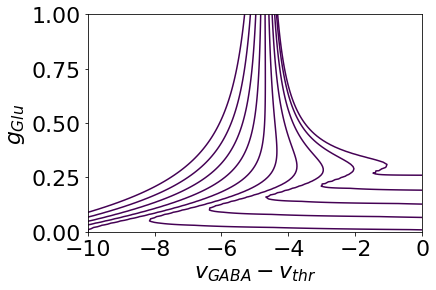

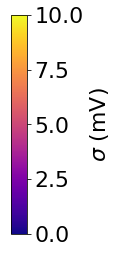

In [39]:
plt.figure()
levels=[0.001] # Define levels 

cmap = mpl.cm.get_cmap('plasma')
n_lines = sigma_list.shape[0]
color_list = [cmap((i+1)/n_lines) for i in range(n_lines)]

for ind in range(len(sigma_list)):
    
    dfrate_selected = dfrate[ind,:,:]
    ct=plt.contour(vi_list+60, ge_list, dfrate_selected, levels)
    
plt.xlabel(r'$v_{GABA}-v_{thr}$');
plt.ylabel(r'$g_{Glu}$');

plt.savefig('heatmap_contours_sigma2to10.svg')


fig, ax = plt.subplots(figsize=(0.3, 8))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'$\sigma$ (mV)')
fig.show()
#plt.savefig('heatmap_contours_sigma2to10_colorbar.svg')
